Amardeep Singh

E23CSEU2189

Using device: cuda
Epoch [1/10] Loss: 0.1648
Epoch [2/10] Loss: 0.0986
Epoch [3/10] Loss: 0.0843
Epoch [4/10] Loss: 0.0761
Epoch [5/10] Loss: 0.0702
Epoch [6/10] Loss: 0.0655
Epoch [7/10] Loss: 0.0619
Epoch [8/10] Loss: 0.0589
Epoch [9/10] Loss: 0.0564
Epoch [10/10] Loss: 0.0543
✅ Training Complete!


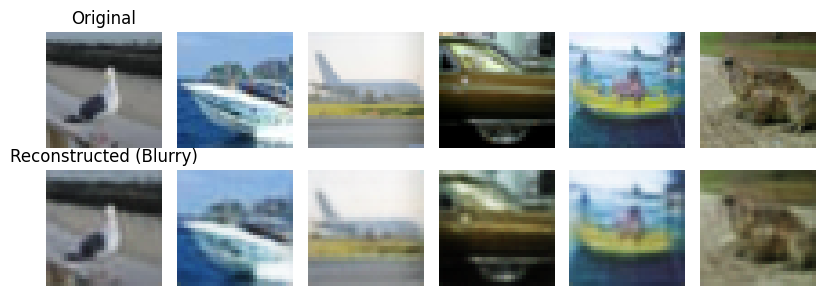

In [ ]:
# ====================================================
# CSET419 - GenAI Lab 5
# Baseline Encoder–Decoder (No GAN)
# CIFAR10 Image Reconstruction
# ====================================================

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# -------------------------------
# 1️⃣ Device
# -------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# -------------------------------
# 2️⃣ Load CIFAR10 Dataset
# Normalize to [-1,1]
# -------------------------------
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5),
                         (0.5, 0.5, 0.5))  # Scale to [-1,1]
])

train_dataset = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=128,
    shuffle=True
)

# -------------------------------
# 3️⃣ Define Encoder–Decoder CNN
# -------------------------------
class EncoderDecoder(nn.Module):
    def __init__(self):
        super(EncoderDecoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1),   # 32 -> 16
            nn.ReLU(),
            nn.Conv2d(64, 128, 4, 2, 1), # 16 -> 8
            nn.ReLU(),
            nn.Conv2d(128, 256, 4, 2, 1),# 8 -> 4
            nn.ReLU()
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, 2, 1), # 4 -> 8
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),  # 8 -> 16
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, 4, 2, 1),    # 16 -> 32
            nn.Tanh()  # Output in [-1,1]
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

model = EncoderDecoder().to(device)

# -------------------------------
# 4️⃣ Loss & Optimizer
# -------------------------------
criterion = nn.L1Loss()      # Can change to nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0002)

# -------------------------------
# 5️⃣ Training Loop
# -------------------------------
epochs = 10

for epoch in range(epochs):
    model.train()
    total_loss = 0

    for images, _ in train_loader:
        images = images.to(device)

        outputs = model(images)
        loss = criterion(outputs, images)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/{epochs}] Loss: {total_loss/len(train_loader):.4f}")

print("✅ Training Complete!")

# -------------------------------
# 6️⃣ Visualization
# -------------------------------

# Convert back from [-1,1] to [0,1]
def denormalize(img):
    img = img * 0.5 + 0.5
    return img.clamp(0, 1)

model.eval()

images, _ = next(iter(train_loader))
images = images.to(device)

with torch.no_grad():
    outputs = model(images)

images = denormalize(images)
outputs = denormalize(outputs)

fig, axes = plt.subplots(2, 6, figsize=(8,3))

for i in range(6):
    axes[0,i].imshow(np.transpose(images[i].cpu().numpy(), (1,2,0)),
                     interpolation='nearest')
    axes[0,i].axis('off')

    axes[1,i].imshow(np.transpose(outputs[i].cpu().numpy(), (1,2,0)),
                     interpolation='nearest')
    axes[1,i].axis('off')

axes[0,0].set_title("Original")
axes[1,0].set_title("Reconstructed (Blurry)")

plt.tight_layout()
plt.show()
